In [21]:
import numpy as np
import osr_methods as osr
import line_search_methods as lsm
import ocr_methods as ocr
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import numdifftools as nd

### Definição do Ponto Inicial

In [22]:
#exterior
#x = np.array([1., 15.])

#interior
x = np.array([0.5, 0.5])

### Escolha dos métodos de OSR e OCR

In [23]:
# Metodos OCR
# 1 - Penalidade
# 2 - Barreira
metodo_ocr = 2

if (metodo_ocr == 1):
    n_met_ocr = "Penalidade"
elif (metodo_ocr == 2):
    n_met_ocr = "Barreira"

# Metodos OSR
# 1 - Univariante
# 2 - Powell
# 3 - Stepest Descent
# 4 - Newton-Raphson
# 5 - Fletcher-Reeves
# 6 - BFGS
metodo_osr = 4

if (metodo_osr == 1):
    n_met = 'Univariante'
elif (metodo_osr == 2):
    n_met = 'Powell'
elif (metodo_osr == 3):
    n_met = 'Steepest Descent'
elif (metodo_osr == 4):
    n_met = 'Newton-Raphson'
elif (metodo_osr == 5):
    n_met = 'Fletcher-Reeves'
elif (metodo_osr == 6):
    n_met = 'BFGS'

### Controle Numérico

In [24]:
# numero maximo de iteracoes na OSR
maxiter = 1000

# tolerancia para convergencia do gradiente na OSR
tol_conv = 1E-3

# tolerancia para a busca unidirecional na OSR
tol_search = 1E-8

# delta alpha do passo constante na OSR
line_step = 1E-4

#epsilon da maquina
eps = 1E-10

#parametros ocr
if metodo_ocr == 1:
    #penalidade
    r = 1E-7
    beta = 10
elif metodo_ocr == 2:
    #barreira
    r = 1E+7
    beta = 0.1

#tolerancia OCR
tol = 1E-3

ctrl_num_osr = [maxiter, tol_conv, tol_search, line_step, eps]

### Definição de f

In [25]:
def f(x):
    rho = 7850
    L = 5    
    return rho*2*np.pi*x[0]*x[1]*L

def grad_f(x):
    rho = 7850
    L = 5
    a = rho*2*np.pi*x[1]*L
    b = rho*2*np.pi*x[0]*L  
    return np.array([a, b])

def hess_f(x):
    rho = 7850
    L = 5
    #termo 1x1
    a = 0.
    #termo 1x2
    b = rho*2*np.pi*L
    #termo 2x1
    c = b
    #termo 2x2
    d = 0.
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

### Definição das restrições de desigualdade

In [26]:
##RESTRICAO 1
def cl1(x):
    P = 100
    E = 210
    I = np.pi*x[0]**3*x[1]
    L = 5
    return P - np.pi**2*E*I/(4*L**2)

def grad_cl1(x):
    P = 100
    E = 210
    I = np.pi*x[0]**3*x[1]
    L = 5
    dI0 = 3*np.pi*x[0]**2*x[1]
    dI1 = np.pi*x[0]**3
    
    a = -np.pi**2*E*dI0/(4*L**2)
    b = -np.pi**2*E*dI1/(4*L**2)
    return np.array([a, b])

def hess_cl1(x):
    P = 100
    E = 210
    I = np.pi*x[0]**3*x[1]
    L = 5
    dI0 = 3*np.pi*x[0]**2*x[1]
    dI1 = np.pi*x[0]**3
    ddI00 = 6*np.pi*x[0]*x[1]
    ddI01 = 3*np.pi*x[0]**2
    ddI11 = 0.
    
    hess = np.zeros((2,2), dtype=float)
    #termo 1x1
    a = -np.pi**2*E*ddI00/(4*L**2)
    #termo 1x2
    b = -np.pi**2*E*ddI01/(4*L**2)
    #termo 2x1
    c = b
    #termo 2x2
    d = -np.pi**2*E*ddI11/(4*L**2)
        
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

##RESTRICAO 2
def cl2(x):
    P = 100
    E = 210
    e = 0.02*x[0]
    c = x[0] + x[1]/2    
    L = 5
    I = np.pi*x[0]**3*x[1] 
    A = 2*np.pi*x[0]*x[1]
    k = np.sqrt(I/A)    
    sigmaA = 250
    
    return (P/A)*(1 + e*c*(1/np.cos(L*np.sqrt(P/(E*A))/k))/(k**2)) - sigmaA

def grad_cl2(x):
    
    P = 100
    C = 0.02
    #e = 0.02*x[0]
    L = 5
    E = 210
    #extraido do sympy
    a = P*(-3*C*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(x[0] + x[1]/2)*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[0]**2*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))**2) + 2*C/(x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) - 2*C*(x[0] + x[1]/2)/(x[0]**2*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))))/(2*np.pi*x[0]*x[1]) - P*(2*C*(x[0] + x[1]/2)/(x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 1)/(2*np.pi*x[0]**2*x[1])
    b = P*(-C*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(x[0] + x[1]/2)*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[0]*x[1]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))**2) + C/(x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))))/(2*np.pi*x[0]*x[1]) - P*(2*C*(x[0] + x[1]/2)/(x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 1)/(2*np.pi*x[0]*x[1]**2)

    return np.array([a, b])

def hess_cl2(x):
    P = 100
    E = 210
    C = 0.02
    # e = C*x[0]
    L = 5
    #extraido do sympy
    a = P*(C*(3*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[0]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) - 4 + 2*(2*x[0] + x[1])/x[0])/(2*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + C*(-24*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 27*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[0]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) - 16 + 8*(2*x[0] + x[1])/x[0] + 18*L**2*P*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))**2/(E*np.pi*x[0]**4*x[1]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))**2) + 9*L**2*P*(2*x[0] + x[1])/(E*np.pi*x[0]**4*x[1]))/(8*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + C*(2*x[0] + x[1])/(x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 1)/(np.pi*x[0]**3*x[1])
    b = P*(C*(-4*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[1]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) - 6*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[0]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 5*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[0]*x[1]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) - 4/x[0] + 6*L**2*P*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))**2/(E*np.pi*x[0]**4*x[1]**2*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))**2) + 3*L**2*P*(2*x[0] + x[1])/(E*np.pi*x[0]**4*x[1]**2))/(4*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + C*(3*L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[0]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) - 4 + 2*(2*x[0] + x[1])/x[0])/(2*x[1]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + C*(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[1]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) - 2)/(2*x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + (C*(2*x[0] + x[1])/(x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 1)/x[1])/(2*np.pi*x[0]**2*x[1])
    c = b
    d = P*(C*L*(-4*np.sqrt(P/(E*np.pi*x[0]*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 3*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[1]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 2*L*P*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))**2/(E*np.pi*x[0]**3*x[1]**2*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))**2) + L*P*(2*x[0] + x[1])/(E*np.pi*x[0]**3*x[1]**2))/(8*x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + C*(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))*(2*x[0] + x[1])*np.sin(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))/(x[1]*np.sqrt(x[0]**2)*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) - 2)/(2*x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + (C*(2*x[0] + x[1])/(x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]*x[1]))/np.sqrt(x[0]**2))) + 1)/x[1])/(np.pi*x[0]*x[1]**2)
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

##RESTRICAO 3
def cl3(x):
    P = 100
    L = 5
    E = 210
    I = np.pi*x[0]**3*x[1]
    delta = 0.25
    e = 0.02*x[0]
    return e*(1/(np.cos(L*np.sqrt(P/(E*I)))) - 1) - delta    
    
def grad_cl3(x):
    #extraido do sympy
    P = 100
    E = 210
    C = 0.02
    # e = C*x[0]
    L = 5

    #dx
    a = -3*C*L*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))/(2*np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))**2) - C + C/np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))
    #dy
    b = -C*L*x[0]*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))/(2*x[1]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))**2)
    return np.array([a, b])

def hess_cl3(x):
    P = 100
    L = 5
    E = 210
    C = 0.02
    #e = C*x[0]
    #extraido do sympy
    a = 3*C*L*(np.sqrt(P/(E*np.pi*x[0]**3*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))/np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))) + 6*L*P*np.sin(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))**2/(E*np.pi*x[0]**3*x[1]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))**2) + 3*L*P/(E*np.pi*x[0]**3*x[1]))/(4*x[0]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))))
    b = C*L*(np.sqrt(P/(E*np.pi*x[0]**3*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))/np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))) + 6*L*P*np.sin(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))**2/(E*np.pi*x[0]**3*x[1]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))**2) + 3*L*P/(E*np.pi*x[0]**3*x[1]))/(4*x[1]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))))
    c = b
    d = C*L*(3*x[0]*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))*np.sin(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))/np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))) + 2*L*P*np.sin(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))**2/(E*np.pi*x[0]**2*x[1]*np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1])))**2) + L*P/(E*np.pi*x[0]**2*x[1]))/(4*x[1]**2*np.cos(L*np.sqrt(P/(E*np.pi*x[0]**3*x[1]))))
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

##RESTRICAO 4
def cl4(x):
    return x[0] - 50*x[1]

def grad_cl4(x):
    return np.array([1., -50.])

def hess_cl4(x):
    hess = np.zeros((2,2), dtype=float)
    return hess

##RESTRICAO 5
def cl5(x):
    return 0.01 - x[0]

def grad_cl5(x):
    return np.array([-1., 0.])

def hess_cl5(x):
    hess = np.zeros((2,2), dtype=float)
    return hess

##RESTRICAO 6
def cl6(x):
    return x[0] - 1

def grad_cl6(x):
    return np.array([1., 0.])

def hess_cl6(x):
    hess = np.zeros((2,2), dtype=float)
    return hess

##RESTRICAO 7
def cl7(x):
    return 0.005 - x[1]

def grad_cl7(x):
    return np.array([0., -1.])

def hess_cl7(x):
    hess = np.zeros((2,2), dtype=float)
    return hess

##RESTRICAO 8
def cl8(x):
    return x[1] - 0.2

def grad_cl8(x):
    return np.array([0., 1.])

def hess_cl8(x):
    hess = np.zeros((2,2), dtype=float)
    return hess

In [27]:
print(hess_cl2(x))
print(nd.Hessian(cl2)(x))


[[13803338.88978371  4596738.86979388]
 [ 4596738.86979388  1548902.6950315 ]]
[[24122.34961583   679.62491992]
 [  679.62491992  1419.86459238]]


In [28]:
# import sympy as sp

# x, y, P, E, C, L, pi = sp.symbols('x y P E C L pi')

# # P = 100
# # E = 210
# # C = 0.02
# e = C*x
# c = x + y/2    
# # L = 5
# A = 2*pi*x*y
# I = pi*x**3*y
# k = sp.sqrt(I/A)
# sigmaA = 250

# deriv = sp.diff((P/A)*(1 + e*c*(1/sp.cos(L*sp.sqrt(P/(E*A))/k))/(k**2)) - sigmaA, y, y)
# print(deriv)



    
#     # return (P/A)*(1 + e*c*(1/np.cos(L*np.sqrt(P/(E*A))/k))/(k**2)) - sigmaA



### Listas de Restrições e suas derivadas

In [29]:
hk_list = []
grad_hk_list = []
hess_hk_list = []

cl_list = [cl1, cl2, cl3, cl4, cl5, cl6, cl7, cl8]
grad_cl_list = [grad_cl1, grad_cl2, grad_cl3, grad_cl4, grad_cl5, grad_cl6, grad_cl7, grad_cl8 ]
hess_cl_list = [hess_cl1, hess_cl2, hess_cl3, hess_cl4, hess_cl5, hess_cl6, hess_cl7, hess_cl8]

#para o metodo de penalidade
#controle de quais cls irao montar a phi
cl_mont = []
if metodo_ocr == 1:
    for cl in cl_list:
        if cl(x) > 0:
            cl_mont.append(1)
        else:
            cl_mont.append(0)
            
params = [f, grad_f, hess_f, hk_list, grad_hk_list, hess_hk_list, cl_list, grad_cl_list, hess_cl_list, cl_mont]


### Otimização

In [30]:

if metodo_ocr == 1:
    parc = (1/2)*r*ocr.p_penal(x, params)
elif metodo_ocr == 2:
    parc = r*ocr.b_bar(x, params)
    
listP_OCR = []
listP_OCR.append(x)

listResultsOSR = []

passos_OCR = 0
redo = 0
print(n_met)
while(parc > tol):
    passos_OCR = passos_OCR + 1
    if passos_OCR > 15:
        break
    if passos_OCR > 1:
        r = beta*r
        # for i in np.arange(len(levellist)):
        #     levellist[i] = beta*levellist[i]
        if metodo_ocr == 1:
            params[-1] = []
            for cl in cl_list:
                if cl(x) > 0:
                    params[-1].append(1)
                else:
                    params[-1].append(0)
    listP_OSR, passos_OSR, conv_OSR, flag_conv_OSR, tempoExec_OSR = osr.osr_ctrl(x, params, r, ctrl_num_osr, metodo_ocr, metodo_osr)
    
    if metodo_ocr == 2:
        redo = 0
        for cl in cl_list:
            if cl(listP_OSR[-1]) > 0:
                redo = 1
                break
    if (redo == 0):
        ctrl_num_osr[3] = line_step
        x = listP_OSR[-1]
        listP_OCR.append(x)
        listResultsOSR.append([listP_OSR, params, r, metodo_ocr, metodo_osr])
        if metodo_ocr == 1:
            parc = (1/2)*r*ocr.p_penal(x, params)
        elif metodo_ocr == 2:
            parc = r*ocr.b_bar(x, params)
        print(f'{passos_OCR}: x={x}, r={r:.1e}, passos={passos_OSR}, conv_OCR={parc:.4e}, conv_OSR={conv_OSR:.4e}')
    elif (redo == 1):
        print(f'Refazendo passo {passos_OCR} com delta alpha = {0.1*ctrl_num_osr[3]}')
        passos_OCR = passos_OCR - 1
        r = r/beta
        ctrl_num_osr[3] = 0.1*ctrl_num_osr[3]
        
        
        plt.close()
    

Newton-Raphson
Refazendo passo 1 com delta alpha = 1e-05
Refazendo passo 1 com delta alpha = 1.0000000000000002e-06


KeyboardInterrupt: 

### Plots de $\phi(x_1,x_2)$ e restrições

In [ ]:
# x1 = np.linspace(0.01,10)
# x2 = np.linspace(0.01,60)
# X1, X2 = np.meshgrid(x1, x2)
# #levellist = [0,50,100,400,800,2000]

# levellist = [0,50, 100, 200, 400 , 600, 1000]

# n_plots = passos_OCR

# fig, ax = plt.subplots(int(np.ceil(n_plots/2)), 2, sharex='col', sharey='row')


# k = 0
# for i in np.arange(int(np.ceil(n_plots/2))):
#     for j in [0,1]:
#         if metodo_ocr == 1:
#             X3 = ocr.phi_penal([X1,X2], listResultsOSR[k][1], listResultsOSR[k][2])
#         elif metodo_ocr == 2:
#             X3 = ocr.phi_bar([X1, X2], listResultsOSR[k][1], listResultsOSR[k][2])
#         niveis = ax[i,j].contour(X1, X2, X3, levellist, colors='black')
#         ax[i,j].clabel(niveis, inline=1, fontsize=8)
#         for hk in hk_list:
#             X3 = hk([X1,X2])
#             ax[i,j].contour(X1, X2, X3, [0], colors='red')
    
#         for cl in cl_list:
#             X3 = cl([X1,X2])
#             ax[i,j].contour(X1, X2, X3, [0], colors='blue')
           
#         x = []
#         y = []
#         for P in listResultsOSR[k][0]:
#             x.append(P[0])
#             y.append(P[1])
#         ax[i,j].plot(x, y, color='g', linewidth='3')
#         #ax[i,j].set_xlabel('$x_1$', fontsize='10')
#         #ax[i,j].set_ylabel('$x_2$', fontsize='10')
#         ax[i,j].grid(linestyle='--')
#         #ax[i,j].set_xticks([-5,-2,0,2,5])
#         titulo = 'Passo ' + str(k+1)
#         ax[i,j].set_title(titulo, fontsize=12)
#         k = k + 1
        
#         # if (metodo_ocr == 1):
#         #      for l in np.arange(len(levellist)):
#         #         levellist[l] = beta*levellist[l]/2
        
#         if k > n_plots - 1:
#             break
#     if k > n_plots - 1:
#         break

# titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ')
# fig.suptitle(titulo, fontsize=14)
# fig.tight_layout()
# plt.figure(figsize=(10,20))
# plt.show()

In [ ]:
x1 = np.linspace(0.01,10)
x2 = np.linspace(0.01,60)
X1, X2 = np.meshgrid(x1, x2)
#levellist = [0,50,100,400,800,2000]

levellist = [200, 300]

n_plots = passos_OCR
k=0
for item in listResultsOSR :
    
    fig, ax = plt.subplots()

    if metodo_ocr == 1:
        X3 = ocr.phi_penal([X1,X2], item[1], item[2])
    elif metodo_ocr == 2:
        X3 = ocr.phi_bar([X1, X2], item[1], item[2])
    niveis = ax.contour(X1, X2, X3, levellist, colors='black')
    ax.clabel(niveis, inline=1, fontsize=8)
    for hk in hk_list:
        X3 = hk([X1,X2])
        ax.contour(X1, X2, X3, [0], colors='red')
    
    for cl in cl_list:
        X3 = cl([X1,X2])
        ax.contour(X1, X2, X3, [0], colors='blue')
           
    x = []
    y = []
    for P in item[0]:
        x.append(P[0])
        y.append(P[1])
    ax.plot(x, y, color='g', linewidth='3')
    #ax[i,j].set_xlabel('$x_1$', fontsize='10')
    #ax[i,j].set_ylabel('$x_2$', fontsize='10')
    ax.grid(linestyle='--')
    #ax[i,j].set_xticks([-5,-2,0,2,5])
    titulo = 'Passo ' + str(k+1)
    ax.set_title(titulo, fontsize=12)
    k = k+1
        
        # if (metodo_ocr == 1):
        #      for l in np.arange(len(levellist)):
        #         levellist[l] = beta*levellist[l]/2
        
  

# titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ')
# fig.suptitle(titulo, fontsize=14)
# fig.tight_layout()
# plt.figure(figsize=(10,20))
plt.show()

### Plot de $f(x_1, x_2)$ e restrições

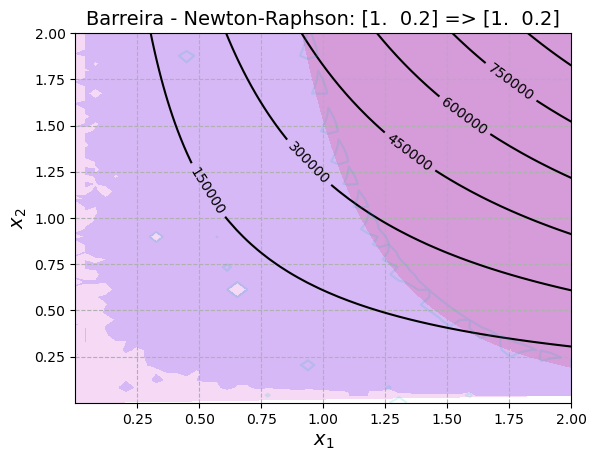

In [ ]:
x1 = np.linspace(0.0001,2, 1000)
x2 = np.linspace(0.0001,2, 1000)
X1, X2 = np.meshgrid(x1, x2)
levellist = [5,15,25,35,45,55,65]

X3 = f([X1, X2])
    
figura, ax = plt.subplots()
        
niveis = ax.contour(X1, X2, X3, colors='black')
ax.clabel(niveis, inline=1, fontsize=10)

# for hk in hk_list:
#     X3 = hk([X1,X2])
#     plt.contour(X1, X2, X3, [0], colors='red')
    
# for cl in cl_list:
#     X3 = cl([X1,X2])
#     plt.contour(X1, X2, X3, [0], colors='blue')
    
X3 = cl1([X1,X2])
plt.contourf(X1, X2, X3, [-100000, 0], colors='r', alpha=0.15)

X3 = cl2([X1,X2])
plt.contourf(X1, X2, X3, [-10000, 0], colors='b', alpha=0.15)

X3 = cl3([X1,X2])
plt.contour(X1, X2, X3, [-10000, 0], colors='c', alpha = 0.15)

X3 = cl4([X1,X2])
plt.contourf(X1, X2, X3, [-10000, 0], colors='m', alpha=0.15)

# X3 = cl5([X1,X2])
# plt.contour(X1, X2, X3, [0], colors='y')

# X3 = cl6([X1,X2])
#plt.contour(X1, X2, X3, [0], colors='brown')
    
x = []
y = []
for P in listP_OCR:
    x.append(P[0])
    y.append(P[1])

ax.plot(x, y, color='g', linewidth='3')
ax.set_xlabel('$x_1$', fontsize='14')
ax.set_ylabel('$x_2$', fontsize='14')
ax.set_ylim(0.0001, 2)
ax.grid(linestyle='--')
titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ') 
ax.set_title(titulo, fontsize='14')
plt.show()

